# Обучение с учителем: качество модели

Задача: интернет-магазин «В один клик» хочет удерживать активность постоянных клиентов. Перед отделом цифровых технологий стоит задача разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

Для этого необходимо:
1. Разработать модель, которая предскажет вероятность снижения покупательской активности.
2. Выделить сегмент покупателей, проанализировать его и предложить, как увеличить его покупательскую активность. Для этого нужно использовать данные моделирования, данные о прибыли покупателей и исходные данные (если понадобятся).

Примеры сегментов:
* Группа клиентов с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности.
* Группа клиентов, которые покупают только технику, то есть товары с длинным жизненным циклом.
* Группа клиентов, которые покупают товары из категории «Товары для себя» (новая категория, которую можно выделить на основе текущих) или «Товары для детей».
* Группа клиентов с высокой вероятностью снижения покупательской активности и наиболее высокой прибыльностью.

## Шаг 1. Загрузка данных

In [1]:
# !pip install numpy==1.26.2 pandas==2.1.4 matplotlib==3.8.2 seaborn==0.13.1 scikit-learn==1.5.1 phik==0.12.4 shap==0.46.0

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
sns.set_style("whitegrid")
import phik
import shap

from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, PolynomialFeatures

from sklearn.impute import SimpleImputer

from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, make_scorer

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

#инициализация моделей
from sklearn.tree         import DecisionTreeClassifier
from sklearn.svm          import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors    import KNeighborsClassifier

from sklearn.pipeline import Pipeline,  make_pipeline
from sklearn.compose import ColumnTransformer


import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", 30)

In [3]:
RANDOM_STATE = 1000

Здесь будем хранить функции, которые будут использованы по ходу работы

In [4]:
# функция для приведения имен колонок к "змеиному" регистру
def snake_case(**dfs):
    updated_dfs = []
    for df_name, df in dfs.items():
        new_col = []
        for col in df.columns:
            col = re.sub(r'[^\w\s]', '', col).lower()
            col = col.replace(' ', '_')
            new_col.append(col)
        df.columns = new_col
        updated_dfs.append(df)
        print(f'Теперь названия колонок датафрейма {df_name} такие: \n{list(df.columns)}')
        print()
    return updated_dfs

# функция для проврки уникальных значений качественных признаков
# я ее использую, чтобы наглядно посмотреть есть ли неявные дубликаты
def unique_check(**dfs):
    for df_name, df in dfs.items():
        categorical = []
        for col in df.columns:
            if df[col].dtype == 'O':
                categorical.append(col)
        for column in categorical:
            print(f'Датафрейм {df_name}. Колонка {column} - ее уникальные значения {df[column].unique()}')
        print()

# функция для отображения лучших моделей, найденных с помощью gridsearchcv
def display_best_models_grided(*mods):
    mod1 = result[[isinstance(clf, mods[0]) for clf in result['param_models']]].head(1)
    for mod in mods[1:]:
        mod1 = pd.concat([mod1, 
                          result[[isinstance(clf, mod) for clf in result['param_models']]].head(1)])
    display(mod1.sort_values(by='rank_test_score'))

In [5]:
try:
    market_file = pd.read_csv('market_file.csv')
    market_money = pd.read_csv('market_money.csv')
    market_time = pd.read_csv('market_time.csv')
    money = pd.read_csv('money.csv', sep=';', decimal=',')    
except:
    market_file = pd.read_csv('https://code.s3.yandex.net/datasets/market_file.csv')
    market_money = pd.read_csv('https://code.s3.yandex.net/datasets/market_money.csv')
    market_time = pd.read_csv('https://code.s3.yandex.net/datasets/market_time.csv')
    money = pd.read_csv('https://code.s3.yandex.net/datasets/money.csv', sep=';', decimal=',')    

In [6]:
dict = {'market_file':market_file, 'market_money':market_money, 'market_time':market_time, 'money':money}
for name, dfr in dict.items():
    print('Информация по таблице', name)
    display(dfr.head(5))
    print('Количество пропусков в таблице:', dfr.isna().sum().sum())
    dups = dfr.duplicated().sum().sum()
    print('Количество явных дубликатов в таблице:', dfr.duplicated().sum().sum())
    print()
    print(dfr.info())
    print()
    print()

Информация по таблице market_file


,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


Количество пропусков в таблице: 0
Количество явных дубликатов в таблице: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукт

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


Количество пропусков в таблице: 0
Количество явных дубликатов в таблице: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB
None


Информация по таблице market_time


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


Количество пропусков в таблице: 0
Количество явных дубликатов в таблице: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB
None


Информация по таблице money


,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


Количество пропусков в таблице: 0
Количество явных дубликатов в таблице: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB
None




### Описание данных

|Наимнование столбца датасета: market_file|Содержание|
|-|-|
|id|номер покупателя в корпоративной базе данных.|
|Покупательская активность|рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».|
|Тип сервиса|уровень сервиса, например «премиум» и «стандарт».|
|Разрешить сообщать|информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.|
|Маркет_актив_6_мес|среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.|
|Маркет_актив_тек_мес|количество маркетинговых коммуникаций в текущем месяце.|
|Длительность|значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.|
|Акционные_покупки|среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.|
|Популярная_категория|самая популярная категория товаров у покупателя за последние 6 месяцев.|
|Средний_просмотр_категорий_за_визит|показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.|
|Неоплаченные_продукты_штук_квартал|общее число неоплаченных товаров в корзине за последние 3 месяца.|
|Ошибка_сервиса|число сбоев, которые коснулись покупателя во время посещения сайта.|
|Страниц_за_визит|среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.|


|Наимнование столбца датасета: market_money|Содержание|
|-|-|
|id|номер покупателя в корпоративной базе данных.|
|Период|название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.|
|Выручка|сумма выручки за период.|

|Наимнование столбца датасета: market_time|Содержание|
|-|-|
|id|номер покупателя в корпоративной базе данных.|
|Период|название периода, во время которого зафиксировано общее время.|
|минут|значение времени, проведённого на сайте, в минутах.|

|Наимнование столбца датасета: money|Содержание|
|-|-|
|id|номер покупателя в корпоративной базе данных.|
|Прибыль|значение прибыли.|

## Шаг 2. Предобработка данных

Приведем названия колонок к общепринятому формату.

In [7]:
market_file, market_money, market_time, money = snake_case(market_file=market_file, 
                                                           market_money=market_money, 
                                                           market_time=market_time, 
                                                           money=money)

Теперь названия колонок датафрейма market_file такие: 
['id', 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать', 'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'популярная_категория', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит']

Теперь названия колонок датафрейма market_money такие: 
['id', 'период', 'выручка']

Теперь названия колонок датафрейма market_time такие: 
['id', 'период', 'минут']

Теперь названия колонок датафрейма money такие: 
['id', 'прибыль']



Пропуски и явные дубликаты отсутствуют. Посмотрим присутствуют ли неявные дубликаты.

In [8]:
unique_check(market_file=market_file, market_money=market_money, market_time=market_time, money=money)

Датафрейм market_file. Колонка покупательская_активность - ее уникальные значения ['Снизилась' 'Прежний уровень']
Датафрейм market_file. Колонка тип_сервиса - ее уникальные значения ['премиум' 'стандартт' 'стандарт']
Датафрейм market_file. Колонка разрешить_сообщать - ее уникальные значения ['да' 'нет']
Датафрейм market_file. Колонка популярная_категория - ее уникальные значения ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']

Датафрейм market_money. Колонка период - ее уникальные значения ['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']

Датафрейм market_time. Колонка период - ее уникальные значения ['текущий_месяц' 'предыдцщий_месяц']




Неявные дубликаты присутствуют в колонке *тип_сервиса* таблицы *market_file*, а также есть опечатка в значениях колонки *период* таблицы *market_time*.
Избавимся от неявных дубликатов, ошибок и приведем все наименования к 'змеиному' регистру

In [9]:
for df in [market_file, market_money, market_time, money]:
    for col in df.columns:
        if df[col].dtype == 'O':
            df[col] = df.loc[:, col].str.lower().map(lambda x: x.replace(' ', '_'))

# убираем опечатку и неявный дубликат
market_file['тип_сервиса'] = market_file.loc[:, 'тип_сервиса'].map(lambda x: x.replace('тт', 'т'))
market_time['период'] = market_time.loc[:, 'период'].map(lambda x: x.replace('предыдцщий_месяц', 'предыдущий_месяц'))

## Шаг 3. Исследовательский анализ данных

In [10]:
for df in [market_file, market_money, market_time, money]:
    display(df.describe().T)

,count,mean,std,min,25%,50%,75%,max
id,1300.0,215997.500000,375.421985,215348.0,215672.75,215997.50,216322.25,216647.00
маркет_актив_6_мес,1300.0,4.253769,1.014814,0.9,3.70,4.20,4.90,6.60
маркет_актив_тек_мес,1300.0,4.011538,0.696868,3.0,4.00,4.00,4.00,5.00
длительность,1300.0,601.898462,249.856289,110.0,405.50,606.00,806.00,1079.00
акционные_покупки,1300.0,0.319808,0.249843,0.0,0.17,0.24,0.30,0.99
средний_просмотр_категорий_за_визит,1300.0,3.270000,1.355350,1.0,2.00,3.00,4.00,6.00
неоплаченные_продукты_штук_квартал,1300.0,2.840000,1.971451,0.0,1.00,3.00,4.00,10.00
ошибка_сервиса,1300.0,4.185385,1.955298,0.0,3.00,4.00,6.00,9.00
страниц_за_визит,1300.0,8.176923,3.978126,1.0,5.00,8.00,11.00,20.00


,count,mean,std,min,25%,50%,75%,max
id,3900.0,215997.500000,375.325686,215348.0,215672.75,215997.5,216322.25,216647.0
выручка,3900.0,5025.696051,1777.704104,0.0,4590.15,4957.5,5363.00,106862.2


,count,mean,std,min,25%,50%,75%,max
id,2600.0,215997.500000,375.349754,215348.0,215672.75,215997.5,216322.25,216647.0
минут,2600.0,13.336154,4.080198,4.0,10.00,13.0,16.00,23.0


,count,mean,std,min,25%,50%,75%,max
id,1300.0,215997.500000,375.421985,215348.00,215672.75,215997.500,216322.25,216647.00
прибыль,1300.0,3.996631,1.013722,0.86,3.30,4.045,4.67,7.43


После предварительного знакомства с данными в глаза бросается макимальная величина выручки в таблице *market_money*, посмотрим по-ближе...

In [11]:
id_err = market_money.loc[market_money['выручка'] > 10000, 'id'].iloc[0]
id_err

215380

In [12]:
market_money[market_money['id'] == id_err]

,id,период,выручка
96,215380,препредыдущий_месяц,5051.0
97,215380,предыдущий_месяц,6077.0
98,215380,текущий_месяц,106862.2


In [13]:
market_file[market_file['id'] == id_err]

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
32,215380,снизилась,премиум,нет,1.7,4,637,0.94,техника_для_красоты_и_здоровья,3,2,4,7


Если честно сложно интерпретировать причину появления такого значения. Пользователь не новый, более 600 дней назад зарегестрировался, пользуется премиум сервисом, но в то же время почти все его покупки по акциям. (минута юмора: наверное то же самое видят DS специалисты OZON, когда кто-то там покупает машину)))

Я бы по возможности уточнил у людей ответственных за выгрузку данных правильность этого значения. Статистически - это выброс, причем очень сильный. Некоторым моделям придется сложно из-за него, поэтому я бы заменил это значение на среднее прерыдущие 2 периода.

In [14]:
market_money.loc[market_money['выручка'] > 10000, 'выручка'] = \
market_money.loc[(market_money['выручка'] < 10000) & (market_money['id'] == id_err), 'выручка'].mean()

In [15]:
market_money.loc[market_money['id'] == id_err]

,id,период,выручка
96,215380,препредыдущий_месяц,5051.0
97,215380,предыдущий_месяц,6077.0
98,215380,текущий_месяц,5564.0


In [16]:
market_files_quantitative = ['маркет_актив_6_мес', 'длительность', 'акционные_покупки']

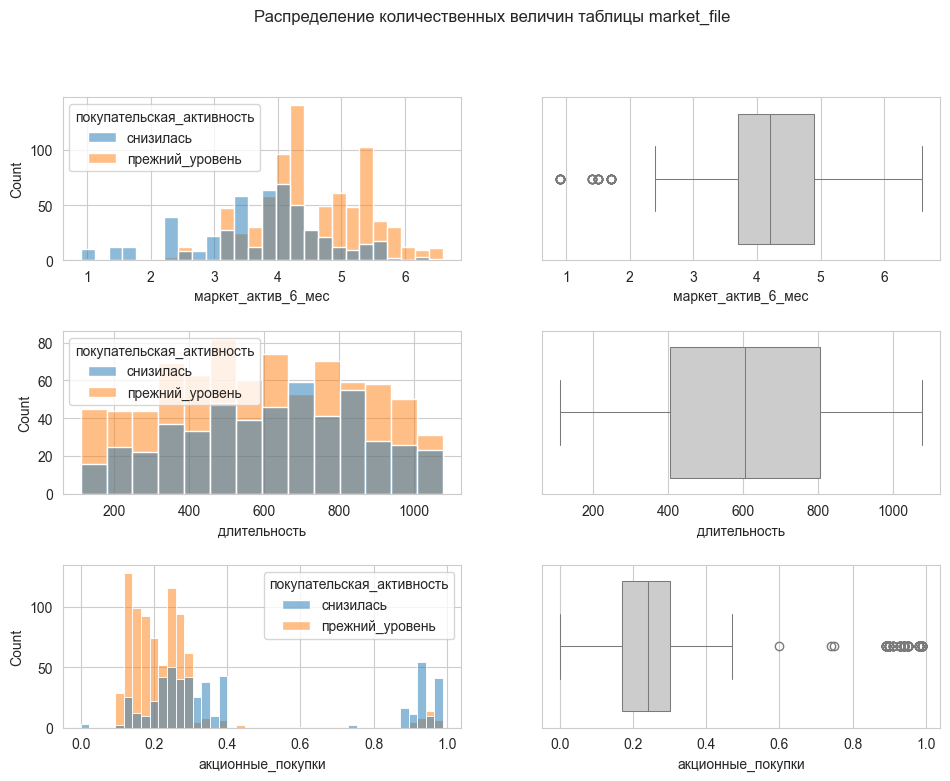

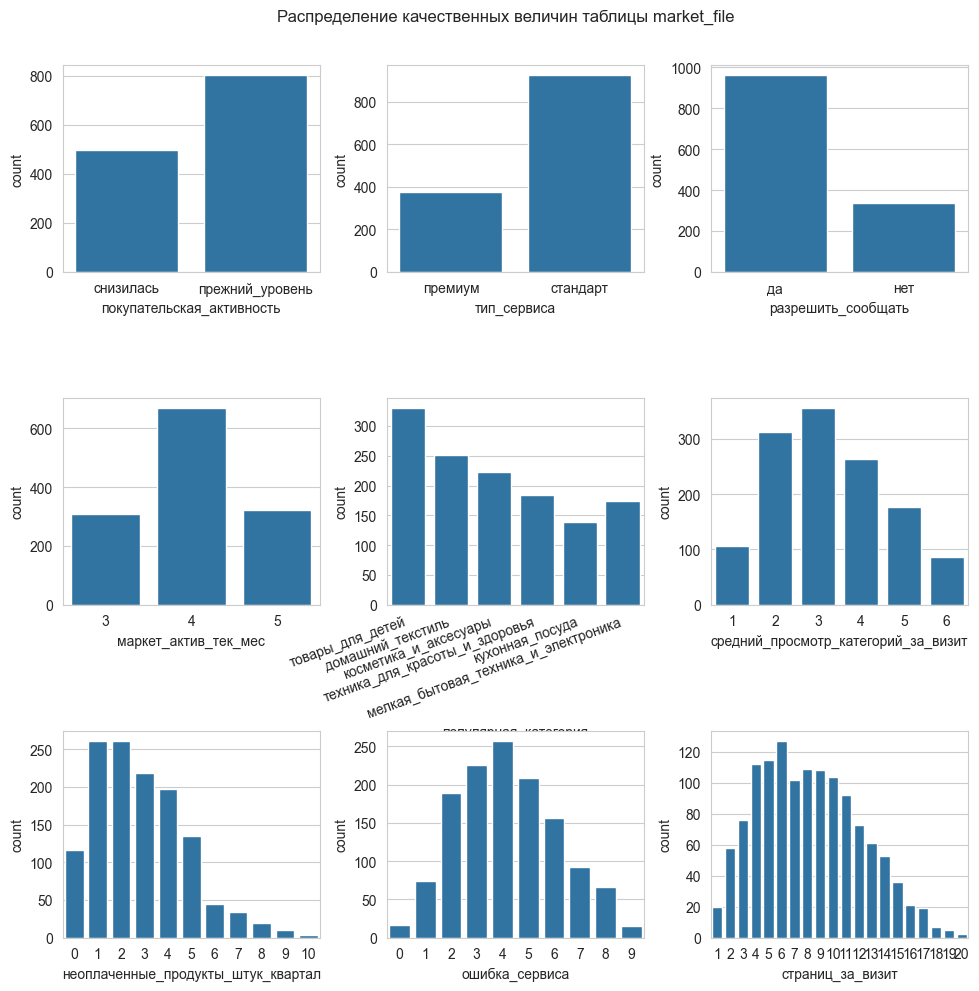

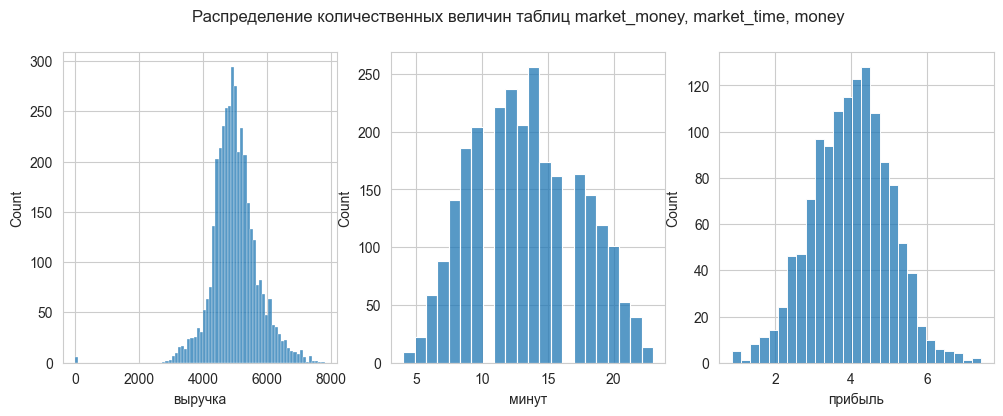

In [17]:
fig, axs = plt.subplots(3, 2, figsize=(10, 8))
fig.suptitle('Распределение количественных величин таблицы market_file')
fig.tight_layout(pad=3, h_pad=3)

for i, param in enumerate(market_files_quantitative):
    sns.boxplot(data=market_file, x=param, ax=axs[i, 1], color=".8", linewidth=.75, orient='h')
    sns.histplot(data=market_file, x=param, hue='покупательская_активность', ax=axs[i, 0])


fig, axs = plt.subplots(3, 3, figsize=(10, 10))
fig.suptitle('Распределение качественных величин таблицы market_file')
fig.tight_layout(pad=2, h_pad=7)
for i, param in enumerate([col for col in market_file.columns if col not in market_files_quantitative and col!='id']):
    sns.countplot(data=market_file, x=param, ax=axs[i//3, i%3])

axs[1,1].set_xticks(ticks=axs[1,1].get_xticks(), labels=axs[1,1].get_xticklabels(), rotation=20, ha='right')


fig, axs = plt.subplots(1, 3, figsize=(10, 4))
fig.suptitle('Распределение количественных величин таблиц market_money, market_time, money')
fig.tight_layout(h_pad=5)
for i, series in enumerate([market_money['выручка'], market_time['минут'], money['прибыль']]):
    sns.histplot(x=series, ax=axs[i])
    
plt.show()

Ознакамливаясь с графиками можно подметить несколько интересных особенностей:
* Среднемесячная доля покупок по акции имеет бимодально распределение. Пользователи разделились на 2 категории - те, которые покупают все только акциям и те, которые пользуются ими время от времени;
* Большинство пользостелей пользуются стандартным типом сервиса, и не разрешают присылать дополнительные предложения о товаре;
* Наиболее популярны категоии: товары для детей и домашний текстиль
* Большая часть данных имеет нормальное распределение.

Также можео заметить клиентов без выручки на одном из последних графиков. Поскольку нас интересуют только активные клиенты от них мы избавимся.Проще всего это будет сделать после объединения таблиц.

<font color='blue'><b>Комментарий ревьюера : </b></font> ✔️\
<font color='green'>Хорошая работа в части исследования данных: молодец, что используешь функции, а также применяешь подходящие для типов данных инструменты.</font>

## Шаг 4. Объединение таблиц

In [18]:
transformed_market_money = market_money.pivot_table(index='id',  columns='период', values='выручка') \
                                       .rename(columns={'предыдущий_месяц':'выручка_за_предыдущий_месяц', 
                                                        'препредыдущий_месяц':'выручка_за_препредыдущий_месяц',
                                                        'текущий_месяц':'выручка_за_текущий_месяц'})

transformed_market_time = market_time.pivot_table(index='id',  columns='период', values='минут') \
                                       .rename(columns={'предыдущий_месяц':'минут_за_предыдущий_месяц', 
                                                        'текущий_месяц':'минут_за_текущий_месяц'})

df_merged = market_file.merge(transformed_market_money, on='id').merge(transformed_market_time, on='id')
display(df_merged.shape)
df_merged.head()

(1300, 18)

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_за_предыдущий_месяц,выручка_за_препредыдущий_месяц,выручка_за_текущий_месяц,минут_за_предыдущий_месяц,минут_за_текущий_месяц
0,215348,снизилась,премиум,да,3.4,5,121,0.00,товары_для_детей,6,2,1,5,0.0,0.0,3293.1,13.0,14.0
1,215349,снизилась,премиум,да,4.4,4,819,0.75,товары_для_детей,4,4,2,5,5216.0,4472.0,4971.6,12.0,10.0
2,215350,снизилась,стандарт,нет,4.9,3,539,0.14,домашний_текстиль,5,2,1,5,5457.5,4826.0,5058.4,8.0,13.0
3,215351,снизилась,стандарт,да,3.2,5,896,0.99,товары_для_детей,5,0,6,4,6158.0,4793.0,6610.4,11.0,13.0
4,215352,снизилась,стандарт,нет,5.1,3,1064,0.94,товары_для_детей,3,2,3,2,5807.5,4594.0,5872.5,8.0,11.0


На этом шаге удобнее всего отобрать клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период.

In [19]:
df_merged = df_merged.query("выручка_за_предыдущий_месяц > 0 and выручка_за_препредыдущий_месяц > 0 and выручка_за_текущий_месяц > 0").copy()

Проверим на наличие пропусков после объединения таблиц:

In [20]:
df_merged.isna().sum()

id                                     0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
выручка_за_предыдущий_месяц            0
выручка_за_препредыдущий_месяц         0
выручка_за_текущий_месяц               0
минут_за_предыдущий_месяц              0
минут_за_текущий_месяц                 0
dtype: int64

In [21]:
df_merged.shape

(1297, 18)

## Шаг 5. Корреляционный анализ

In [22]:
quantitative = ['маркет_актив_6_мес',
                'длительность',
                'акционные_покупки',
                'выручка_за_предыдущий_месяц',
                'выручка_за_препредыдущий_месяц',
                'выручка_за_текущий_месяц',
                'минут_за_предыдущий_месяц',
                'минут_за_текущий_месяц']

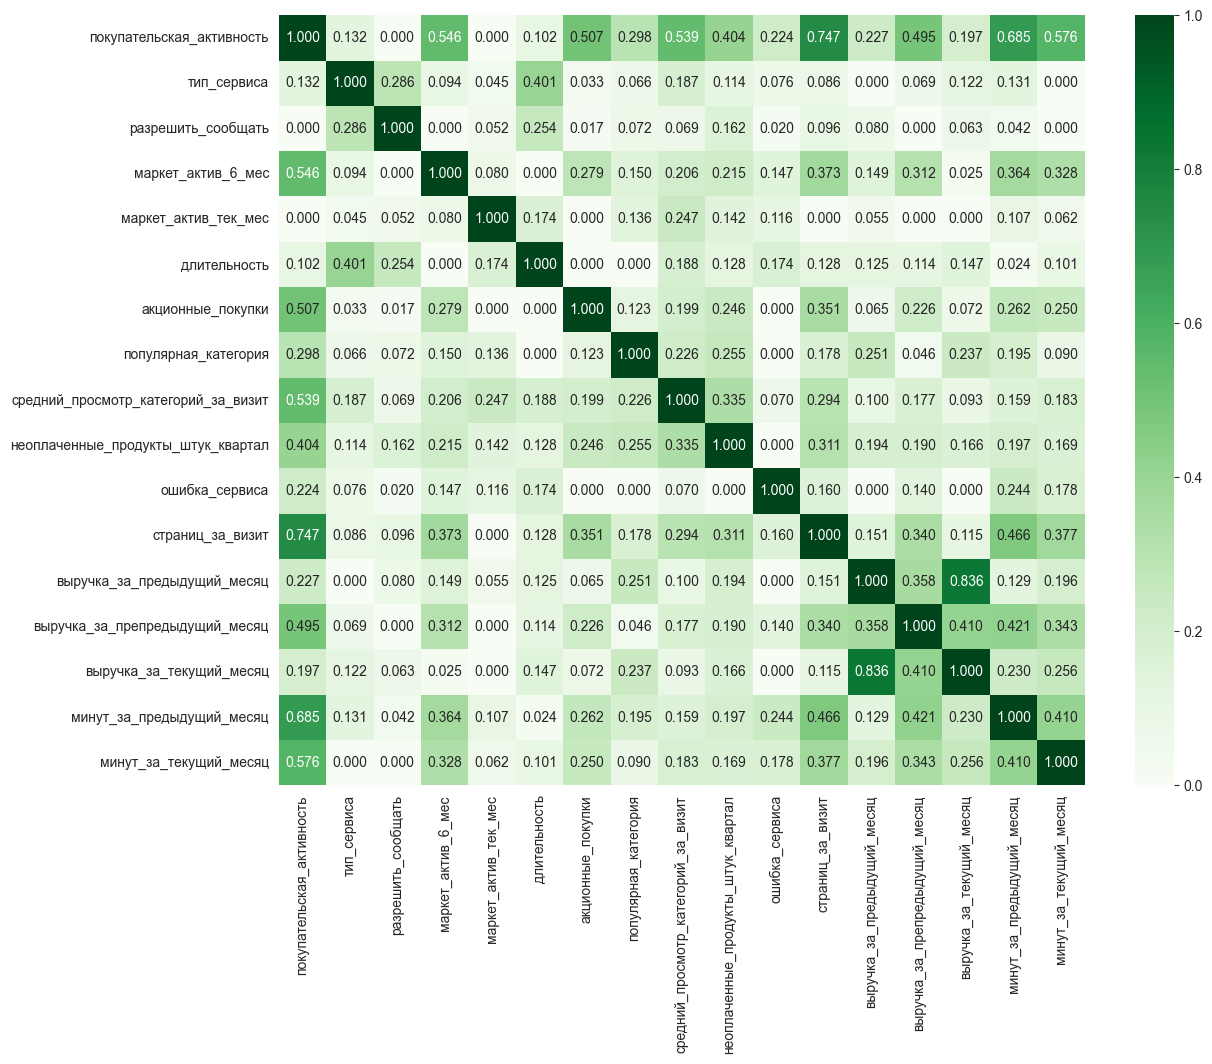

In [23]:
fig, axs = plt.subplots(1, 1, figsize=(13, 10))
sns.heatmap(df_merged.drop('id', axis=1).phik_matrix(interval_cols=quantitative), annot=True, cmap='Greens', fmt=".3f", ax=axs);
corr_heat_matrix = plt.gcf()

По результатам корреляционного анализа мультиколлинеарность не выявлена.

## Шаг 6. Использование пайплайнов

Перед началом машинного обучения вручную закодируем целевой признак.

0 - покупательская активность на прежнем уровне

1 - покупательская активность снизилась

In [24]:
df_merged['покупательская_активность'] = df_merged['покупательская_активность'].map(lambda x: 0 if x=='снизилась' else 1)

In [25]:
X = df_merged.drop(['покупательская_активность', 'id'], axis=1)
y = df_merged['покупательская_активность']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = RANDOM_STATE, stratify=y)

In [27]:
coded_cols = ['тип_сервиса', 'разрешить_сообщать', 'маркет_актив_тек_мес', 'популярная_категория']
num_cols = [col for col in X_train.columns if X_train[col].dtype != 'O' and col != 'маркет_актив_тек_мес']

In [28]:
encoder_pipe = Pipeline(
    [
        ('encoder',  OrdinalEncoder(categories=[['стандарт', 'премиум'], 
                                            ['нет', 'да'],
                                            [3, 4, 5],
                                            ['товары_для_детей', 'домашний_текстиль', 'косметика_и_аксесуары',
                                             'техника_для_красоты_и_здоровья', 'кухонная_посуда',
                                             'мелкая_бытовая_техника_и_электроника']], 
                                             handle_unknown='use_encoded_value', 
                                             unknown_value=np.nan)),
        ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)


In [29]:
data_preprocessor = ColumnTransformer(
    [
    ('encoder', encoder_pipe, coded_cols),
    ('num', StandardScaler(), num_cols)
    ], 
    remainder='passthrough'
)

In [30]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression(random_state=RANDOM_STATE))
])

In [31]:
param_preprocessor_encoder = [OrdinalEncoder(categories=[['стандарт', 'премиум'], ['нет', 'да'], [3, 4, 5],
                                                            ['товары_для_детей', 'домашний_текстиль', 'косметика_и_аксесуары',
                                                             'техника_для_красоты_и_здоровья', 'кухонная_посуда',
                                                             'мелкая_бытовая_техника_и_электроника']], 
                                                             handle_unknown='use_encoded_value', 
                                                             unknown_value=np.nan),
                                 OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
                                ]

param_num_scaler = [StandardScaler(), MinMaxScaler(), RobustScaler()]

In [32]:
param_grid = [
    # словарь для модели DecisionTreeClassifier
    {
        'models':[DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth':range(2, 7),
        'models__max_features':range(2, 10),
        
        'preprocessor__num':param_num_scaler,        
    },
    # словарь для модели KNeighborsClassifier
    {
        'models':[KNeighborsClassifier()],
        'models__n_neighbors': range(5, 11),
        
        'preprocessor__encoder':param_preprocessor_encoder,
        'preprocessor__num':param_num_scaler
    },
    # словарь для модели SVM
    {
        'models':[SVC(random_state=RANDOM_STATE,
                      probability=True)],
        'models__C': [0.01, 0.1, 0.5, 1], 
        'models__gamma': [0.01, 0.1, 0.5, 1],
        
        'preprocessor__encoder':param_preprocessor_encoder,
        'preprocessor__num':param_num_scaler
    },
    # словарь для модели LogisticRegression
    {
        'models': [LogisticRegression(penalty = 'l1',
                                      solver='saga',
                                      random_state=RANDOM_STATE,
                                      class_weight='balanced')],
        'models__C':[0.1, 0.25, 0.5, 1],
        
        'preprocessor__encoder':param_preprocessor_encoder,
        'preprocessor__num':param_num_scaler
    }
]

Для оценки качетсва модели будем использовать метрику ROC-AUC, для того, чтобы оценка качества модели не зависела от порогов вероятности.

Для данной задачи, на мой взгляд, важно правильно предсказывать как ошибки первого рода, так и второго, потому что если покупательская активность (0 - прежний уровень, 1 - снизилась) клиента будет идентифицирована как FP, то компания будет тратить лишние деньги на удержание клиента предлагая дополнительные акции, скидки, выгодные предложения. Еще хуже FN, клиент со снижающейся активностью будет ложно идентифицирован как 0 (прежний уровень) и при отсутствии механизсов удержания может покинуть платформу. 

Поэтому важно правильно классифицировать оба класса целевого признака.

In [33]:
grid_search = GridSearchCV(pipe_final,
                           param_grid,
                           cv=5,
                           scoring='roc_auc',
                           n_jobs=-1)

In [34]:
grid_search = grid_search.fit(X_train, y_train)

In [35]:
result = pd.DataFrame(grid_search.cv_results_).sort_values('rank_test_score')
y_test_pred = grid_search.predict(X_test)
y_probabiliy_one = grid_search.predict_proba(X_test)[:,1]

In [36]:
print('Всего обучено моделей:', result.shape[0])
print('Лучшая модель и её параметры:\n\n', grid_search.best_estimator_, '\n')
print ('Метрика лучшей модели на тренировочной выборке:', grid_search.best_score_)

Всего обучено моделей: 276
Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['тип_сервиса',
                                                   'разрешить_сообщать',
                                                   'маркет_актив_тек_мес',
                                                   'популярная_категория']),
                                                 ('num', StandardScaler(),
                                                  ['маркет_актив_6_мес',
                                                   'длительность',
                            

0.91% на тестовой выборке - на мой взгляд не самый плохой результат. Посмотрим как обстоят дела у других моделей. Выведем лучших представителей. 

In [37]:
display_best_models_grided(DecisionTreeClassifier, KNeighborsClassifier, SVC, LogisticRegression)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_models,param_models__max_depth,param_models__max_features,param_preprocessor__num,param_models__n_neighbors,param_preprocessor__encoder,param_models__C,param_models__gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
243,0.158638,0.007868,0.019253,0.000981,"SVC(probability=True, random_state=1000)",NaN,NaN,StandardScaler(),NaN,"OneHotEncoder(drop='first', handle_unknown='ig...",1.0,0.5,"{'models': SVC(probability=True, random_state=...",0.901556,0.897253,0.915878,0.913739,0.930518,0.911789,0.011725,1
265,0.025467,0.001659,0.005013,0.000549,"LogisticRegression(class_weight='balanced', pe...",NaN,NaN,MinMaxScaler(),NaN,"OrdinalEncoder(categories=[['стандарт', 'преми...",0.5,NaN,{'models': LogisticRegression(class_weight='ba...,0.897667,0.900380,0.908559,0.892342,0.909910,0.901771,0.006633,68
155,0.008730,0.000252,0.005901,0.000565,KNeighborsClassifier(),NaN,NaN,RobustScaler(),10.0,"OneHotEncoder(drop='first', handle_unknown='ig...",NaN,NaN,"{'models': KNeighborsClassifier(), 'models__n_...",0.908611,0.879048,0.900056,0.906081,0.911655,0.901090,0.011662,71
37,0.009526,0.000777,0.004211,0.000750,DecisionTreeClassifier(random_state=1000),3.0,6.0,MinMaxScaler(),NaN,NaN,NaN,NaN,{'models': DecisionTreeClassifier(random_state...,0.858000,0.872068,0.878547,0.867568,0.862331,0.867703,0.007207,145


Лучше всего с данной задачей справились такие модели как:
1. Метод *опортных векторов* с коэф.: *C=1, gamma=0.1* (масштабирование StandardScaler, кодирование OneHotEncoder) **mean_test_score=0.91**;
2. Логистическая регресия с коэф.: *C=0.5* mean_test_score=0.90;
3. Метод *K-ближайших сосдей* с параметром *n_neighbors=10* (масштабирование StandardScaler, кодирование OneHotEncoder) **mean_test_score=0.90**;
4. Хуже всех справилось дерево решений с *max_depth=3*, *max_features=6* **mean_test_score=0.86**.

In [38]:
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_probabiliy_one)}')

Метрика ROC-AUC на тестовой выборке: 0.9246910608249077


Лучшей моделью оказалась модель SVC. Поскольку заказчику важно детально интерпретировать значимость входных признаков, то выберем лучшую модель, по которой это сделать это проще всего. Благо она у нас не в аутсайдерах. Посмотри какие результаты она сможет нам дать на тестовой выборке.

In [39]:
target_model = LogisticRegression

In [40]:
# находим строку с интересующей нас моделью
target_string = result[[isinstance(clf, target_model) for clf in result['param_models']]].iloc[0]

# создаем пайплайн из лучшей модели логистической регресси
data_preprocessor = ColumnTransformer(
    [
    ('encoder', target_string['param_preprocessor__encoder'], coded_cols),
    ('num', target_string['param_preprocessor__num'], [col for col in X_train.columns if X_train[col].dtype != 'O' and col != 'маркет_актив_тек_мес'])
    ], 
    remainder='passthrough'
)
best_pipeline_target_model = Pipeline([('preprocessor', data_preprocessor), 
                                        ('models', target_string['param_models'])
                                       ]
                                      )


best_pipeline_target_model.fit(X_train, y_train)

y_pred_trg = best_pipeline_target_model.predict(X_test)
y_probabiliy_one_trg = best_pipeline_target_model.predict_proba(X_test)[:, 1]


print ('Метрика лучшей модели на тренировочной выборке:', target_string['mean_test_score'], '\n')
print(f'Метрика ROC-AUC на тестовой выборке:   {roc_auc_score(y_test, y_probabiliy_one_trg)}')
print(f'Метрика Accuracy на тестовой выборке:  {accuracy_score(y_test, y_pred_trg)}')
print(f'Метрика F1 на тестовой выборке:        {f1_score(y_test, y_pred_trg)}', '\n')

print('Pipeline наиблучшей модели:')

display(target_string['params'])

Метрика лучшей модели на тренировочной выборке: 0.9017714392078029 

Метрика ROC-AUC на тестовой выборке:   0.9114909324346011
Метрика Accuracy на тестовой выборке:  0.8584615384615385
Метрика F1 на тестовой выборке:        0.8844221105527639 

Pipeline наиблучшей модели:


{'models': LogisticRegression(class_weight='balanced', penalty='l1', random_state=1000,
                    solver='saga'),
 'models__C': 0.5,
 'preprocessor__encoder': OrdinalEncoder(categories=[['стандарт', 'премиум'], ['нет', 'да'], [3, 4, 5],
                            ['товары_для_детей', 'домашний_текстиль',
                             'косметика_и_аксесуары',
                             'техника_для_красоты_и_здоровья', 'кухонная_посуда',
                             'мелкая_бытовая_техника_и_электроника']],
                handle_unknown='use_encoded_value', unknown_value=nan),
 'preprocessor__num': MinMaxScaler()}

91,1% для auc_roc - приемлемый результат. Хуже, конечно, чем у модели SVC (на 1,3%), но не критично. Будем использовать данную модель для анализа признаков.

## Шаг 7. Анализ важности признаков

In [41]:
X_train_trg = pd.DataFrame(
    best_pipeline_target_model.named_steps['preprocessor'].transform(X_train),
    columns=best_pipeline_target_model.named_steps['preprocessor'].get_feature_names_out()
)
X_test_trg = pd.DataFrame(
    best_pipeline_target_model.named_steps['preprocessor'].transform(X_test),
    columns=best_pipeline_target_model.named_steps['preprocessor'].get_feature_names_out()    
)

In [42]:
explainer = shap.LinearExplainer(best_pipeline_target_model.named_steps['models'], X_train_trg)
shap_values = explainer(X_test_trg)

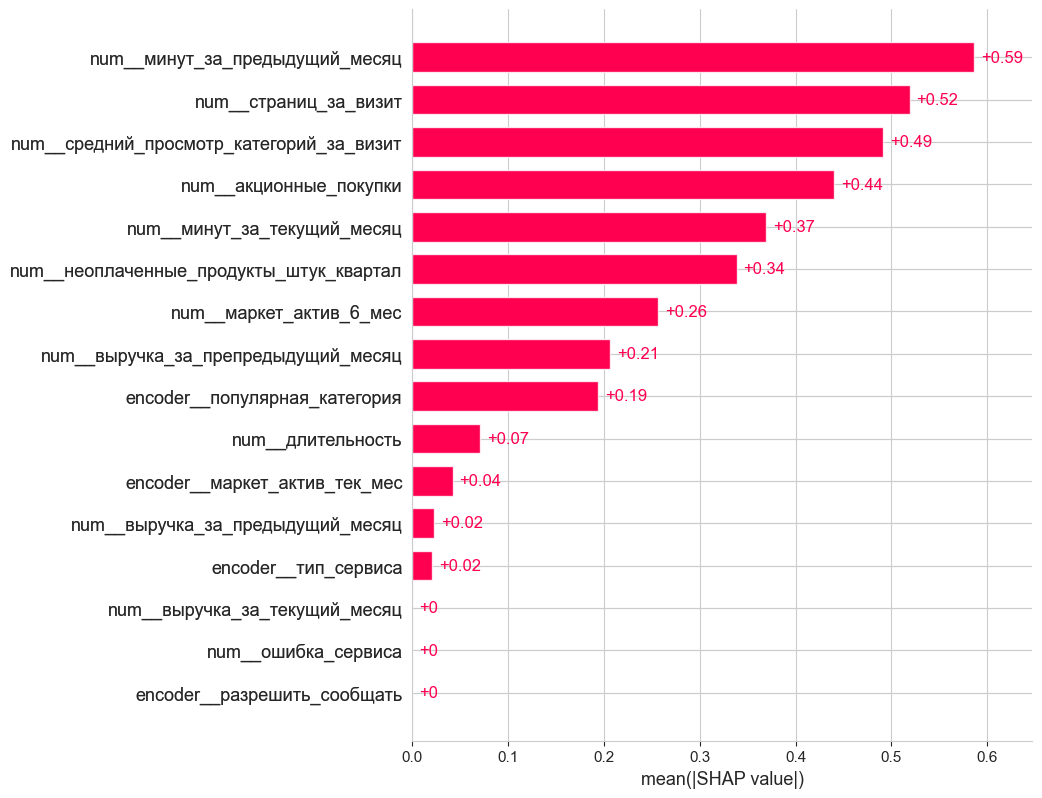

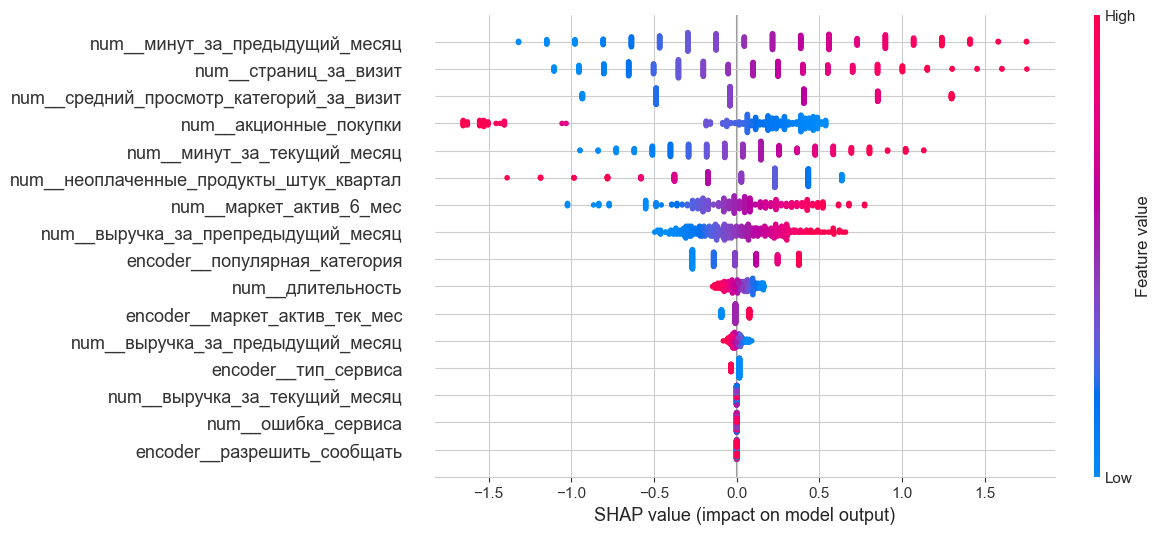

In [43]:
shap.plots.bar(shap_values, max_display=17)
shap.plots.beeswarm(shap_values, max_display=16, plot_size=(10,6)) 

Получилась картина, в которой модель имеет несколько признаков с похожей значимостью. 

Глядя на эту картину хочется немного поработать с призаками и посмотреть на результат. Например, выручка за препредыдущий месяц и прерыдущий месяц "смотрят" в разные стороны, поэтому при одинаковых (стабильных) значениях от месяца к месяцу будут компенсировать значимость друг друга. Значимость  количества минут, проведенного на сайте в текущем и прерыдущем месяце тоже похожа.

Немного модифицируем признаки и обучим новую модель логистической регрессии, заодно попробуем продобрать еще более оптимальный коэффициент регулярихации модели.

<span style="color: blue; font-weight: bold">Комментарий ревьюера : </span> ✔️\
<span style="color: green"> 👍</span>

In [44]:
df_new = df_merged.copy()

In [45]:
df_new['среднее_минут_за_2_месяца'] = (df_new['минут_за_предыдущий_месяц'] + df_new['минут_за_текущий_месяц']) / 2
df_new['средняя_выручка_за_пред_месяцы'] = (df_new['выручка_за_предыдущий_месяц'] + df_new['выручка_за_препредыдущий_месяц']) / 2

df_new = df_new.drop(['выручка_за_предыдущий_месяц', 
                            'выручка_за_препредыдущий_месяц', 
                            'минут_за_предыдущий_месяц', 
                            'минут_за_текущий_месяц'], axis=1)

X_new = df_new.drop(['покупательская_активность', 'id'], axis=1)
y_new = df_new['покупательская_активность']

X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, test_size = 0.25, random_state = RANDOM_STATE, stratify=y_new)

In [46]:
coded_cols_new = ['тип_сервиса', 'разрешить_сообщать', 'маркет_актив_тек_мес', 'популярная_категория']
num_cols_new = [col for col in X_train_new.columns if X_train_new[col].dtype != 'O' and col != 'маркет_актив_тек_мес']

In [47]:
data_preprocessor_log = ColumnTransformer(
    [
    ('ord', OrdinalEncoder(categories=[['стандарт', 'премиум'], 
                                            ['нет', 'да'],
                                            [3, 4, 5],
                                            ['товары_для_детей', 'домашний_текстиль', 'косметика_и_аксесуары',
                                             'техника_для_красоты_и_здоровья', 'кухонная_посуда',
                                             'мелкая_бытовая_техника_и_электроника']], 
                                             handle_unknown='use_encoded_value', unknown_value=np.nan), 
     coded_cols_new),
    ('num', MinMaxScaler(), num_cols_new)
    ], 
    remainder='passthrough'
)

In [48]:
pipe_log = Pipeline([
    ('preprocessor', data_preprocessor_log),
    ('models', LogisticRegression(penalty = 'l1',
                                  solver='saga',
                                  random_state=RANDOM_STATE,
                                  class_weight='balanced')
    )
])


In [49]:
grid_search_new = GridSearchCV(pipe_log,
                               {
                                   'models__C':[round(i, 2) for i in np.linspace(0.01, 1, 20).tolist()],
                                   'preprocessor__num':[StandardScaler(), MinMaxScaler(), RobustScaler()]
                               },
                               cv=5,
                               scoring='roc_auc',
                               n_jobs=-1)

In [50]:
grid_search_new.fit(X_train_new, y_train_new)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ord',
                                                                         OrdinalEncoder(categories=[['стандарт',
                                                                                                     'премиум'],
                                                                                                    ['нет',
                                                                                                     'да'],
                                                                                                    [3,
                                                                                                     4,
                                                                                                     5],
                                                                                                    ['товары_для_детей',
                                                                                                     'домашний_текстиль',
                                                                                                     'косметика_и_аксесуары',
                                                                                                     'техника_для_красоты_и_здоровья',
                                                                                                     'кухонная_посуда',
                                                                                                     'мелкая_бытовая_техника_и_электроника']],...
                                                                          'средняя_выручка_за_пред_месяцы'])])),
                                       ('models',
                                        LogisticRegression(class_weight='balanced',
                                                           penalty='l1',
                                                           random_state=1000,
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'models__C': [0.01, 0.06, 0.11, 0.17, 0.22, 0.27, 0.32,
                                       0.37, 0.43, 0.48, 0.53, 0.58, 0.64, 0.69,
                                       0.74, 0.79, 0.84, 0.9, 0.95, 1.0],
                         'preprocessor__num': [StandardScaler(), MinMaxScaler(),
                                               RobustScaler()]},
             scoring='roc_auc')

In [51]:
result_new = pd.DataFrame(grid_search_new.cv_results_).sort_values('rank_test_score')
y_test_pred_new = grid_search_new.predict(X_test_new)
y_test_probabiliy_new = grid_search_new.predict_proba(X_test_new)[:, 1]

print('Лучшая модель и её параметры:\n\n', grid_search_new.best_estimator_, '\n')
print ('Метрика ROC-AUC лучшей модели на тренировочной выборке:', grid_search_new.best_score_)

print(f'Метрика ROC-AUC на тестовой выборке:   {roc_auc_score(y_test_new, y_test_probabiliy_new)}')
print(f'Метрика Accuracy на тестовой выборке:  {accuracy_score(y_test_new, y_test_pred_new)}')
print(f'Метрика F1 на тестовой выборке:        {f1_score(y_test_new, y_test_pred_new)}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  OrdinalEncoder(categories=[['стандарт',
                                                                              'премиум'],
                                                                             ['нет',
                                                                              'да'],
                                                                             [3,
                                                                              4,
                                                                              5],
                                                                             ['товары_для_детей',
                                                                              'домашний_текстиль',
                           

In [52]:
best_log_pipeline = grid_search_new.best_estimator_
best_log_pipeline.fit(X_train_new, y_train_new)

# "вытаскиваем" тестовые и обучающие данные
X_train_new_log = pd.DataFrame(
    best_log_pipeline.named_steps['preprocessor'].fit_transform(X_train_new),
    columns=best_log_pipeline.named_steps['preprocessor'].get_feature_names_out()
)
X_test_new_log = pd.DataFrame(
    best_log_pipeline.named_steps['preprocessor'].transform(X_test_new),
    columns=best_log_pipeline.named_steps['preprocessor'].get_feature_names_out()    
)

In [53]:
explainer = shap.LinearExplainer(best_log_pipeline.named_steps['models'], X_train_new_log)
shap_values = explainer(X_test_new_log)

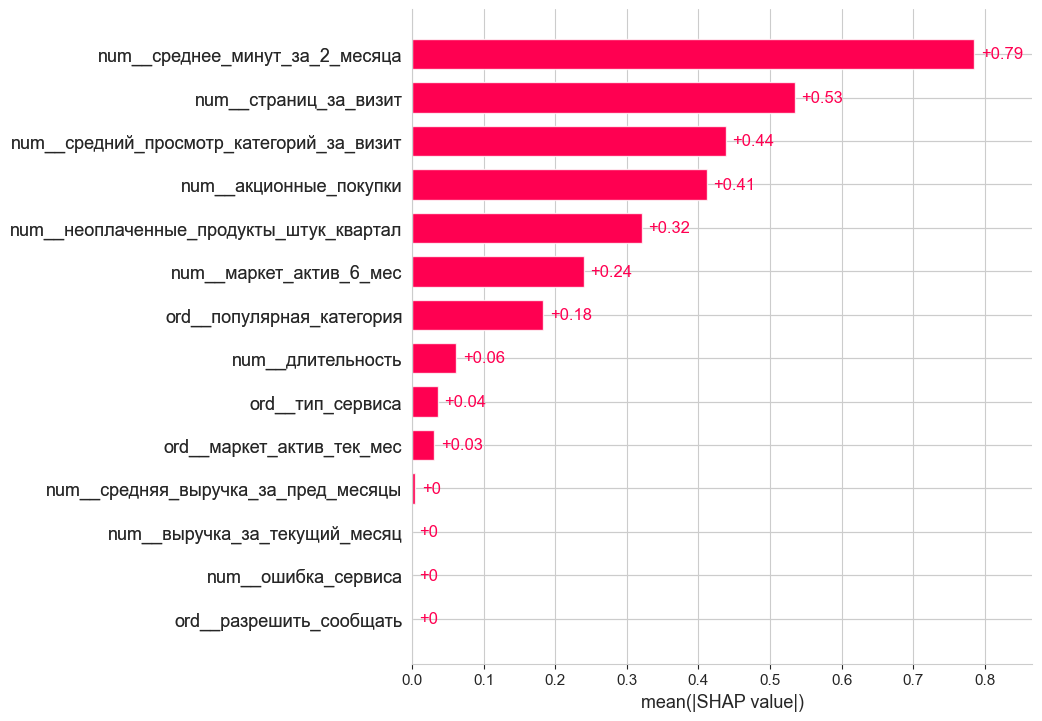

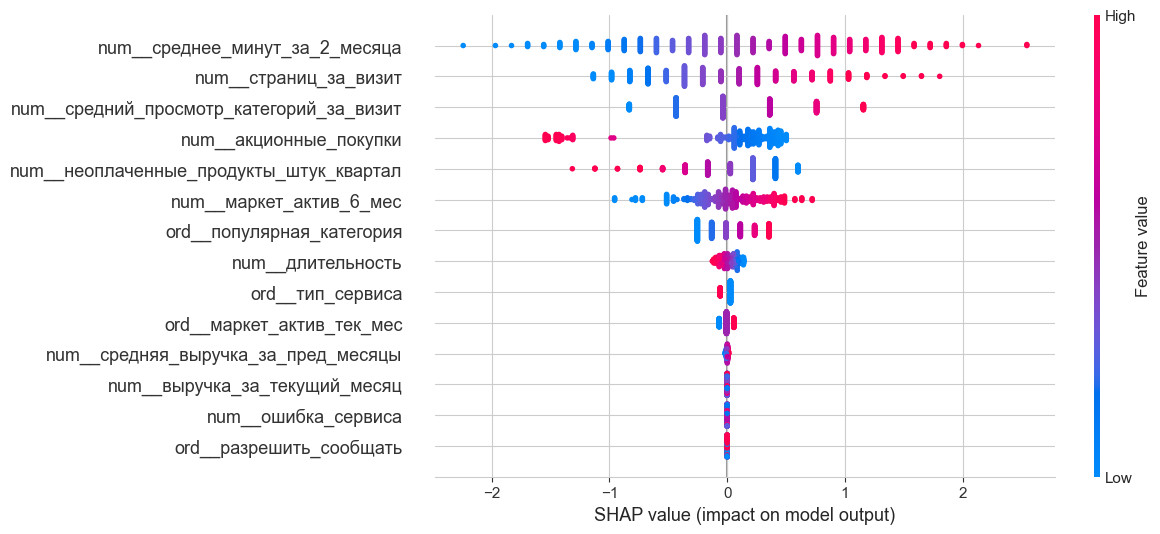

In [54]:
shap.plots.bar(shap_values, max_display=17)
shap.plots.beeswarm(shap_values, max_display=16, plot_size=(10,6)) 

После небольших преобразований признаков качество всех метрик незначительно улучшились (спасибо что не стало хуже). Однако модель стала слишком сильно оценивать вкладодного признака по сравнению с другими.

В данных определился ТОП признаков по степени важности:
1. Среднее **количество минут**, проведенных пользователем за последние 2 месяца. \
(при увеличении признака модель начинает склоняться к присваиванию класса 1)

2. Среднее **количество страниц**, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.\
(при увеличении признака модель начинает склоняться к присваиванию класса 1)

3. Среднемесячное **количество просмотров категорий** за визит в течение последнего месяца. \
(при увеличении признака модель начинает склоняться к присваиванию класса 1)

4. Среднемесячная **доля покупок по акции** от общего числа покупок за последние 6 месяцев. \
(при увеличении признака модель начинает склоняться к присваиванию класса 0)

5. Среднемесячное **значение маркетинговых коммуникаций** компании, которое приходилось на покупателя **за** последние **6 месяцев**. \
(при увеличении признака модель начинает склоняться к присваиванию класса 1)

6. Общее **число неоплаченных товаров в корзине** за последние 3 месяца. \
(при увеличении признака модель начинает склоняться к присваиванию класса 0)

## Шаг 8. Сегментация покупателей

В качестве сегмента для анализа мне хочется выбрать группу клиентов с высокой вероятностью снижения покупательской активности и наиболее высокой прибыльностью.

Перед началом анализа и выделением данного сегмента объединим таблицы объединим итоговый датафрейм с таблицей money/

In [55]:
df = df_new.merge(money, on='id')
df.sample(6)

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_за_текущий_месяц,среднее_минут_за_2_месяца,средняя_выручка_за_пред_месяцы,прибыль
461,215812,0,стандарт,нет,3.3,3,563,0.12,домашний_текстиль,4,1,5,16,7167.4,9.5,5135.00,4.37
170,215521,0,премиум,нет,1.5,3,541,0.90,товары_для_детей,2,4,4,5,4650.8,12.0,4155.00,3.58
509,215860,1,стандарт,да,5.5,5,242,0.21,кухонная_посуда,5,4,4,11,3979.6,18.5,4409.25,5.34
599,215950,1,стандарт,да,3.9,5,827,0.25,мелкая_бытовая_техника_и_электроника,6,1,4,8,5869.4,12.0,4769.75,4.51
823,216174,1,стандарт,нет,5.8,5,852,0.17,косметика_и_аксесуары,3,0,6,5,5040.4,16.5,5406.50,4.12
416,215767,1,премиум,да,4.1,4,316,0.12,товары_для_детей,2,3,4,6,4379.3,16.0,5005.50,3.83


Воспользуемся тем, что разбиение у нас статично из-за зафиксированного random_state, а значит если передать таблицу с таким же количестом строк, они разобьются одинаково.

In [56]:
X_train_else, X_test_else, y_train_else, y_test_else = train_test_split(
    df.drop('покупательская_активность', axis=1),
    df['покупательская_активность'],
    test_size = 0.25, random_state = RANDOM_STATE, stratify=df['покупательская_активность'])

In [57]:
y_train_proba = best_log_pipeline.predict_proba(X_train_new)[:,1]
y_test_proba = best_log_pipeline.predict_proba(X_test_new)[:,1]

In [58]:
X_train_else.reset_index(drop=True, inplace=True)
X_train_else['вер_класса_1'] = pd.Series(y_train_proba)

X_test_else.reset_index(drop=True, inplace=True)
X_test_else['вер_класса_1'] = pd.Series(y_test_proba)

In [59]:
df_esle = pd.concat([X_train_else, X_test_else], axis=0)
df_esle.head()

,id,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_за_текущий_месяц,среднее_минут_за_2_месяца,средняя_выручка_за_пред_месяцы,прибыль,вер_класса_1
0,215563,премиум,да,3.9,5,956,0.35,косметика_и_аксесуары,2,2,6,7,6114.5,9.5,5510.75,6.88,0.164055
1,216492,стандарт,да,4.0,5,742,0.23,техника_для_красоты_и_здоровья,3,2,5,3,4822.8,11.5,4639.50,1.68,0.323472
2,216110,премиум,да,5.1,4,549,0.24,товары_для_детей,2,5,6,12,4651.0,15.0,4609.00,4.95,0.618374
3,215609,премиум,да,3.8,5,636,0.94,косметика_и_аксесуары,3,2,6,3,5747.8,8.0,4587.75,4.29,0.027020
4,216402,стандарт,да,4.9,3,378,0.17,товары_для_детей,5,4,2,13,5287.1,16.0,5153.00,2.99,0.922791


В итоге мы получили датафрейм со значениями прибыли и вероятностями, но для анализа возьмем меньший сегсент (X_test выборку), потому что не совсем верно будет оценивать вероятности значений, на которых модель обучалась. 

In [60]:
limit = np.percentile(df_esle['прибыль'], 65)

In [61]:
target_segment = df_esle.query("вер_класса_1 > 0.7 and прибыль > @limit")
non_target_segment = df_esle.query("вер_класса_1 < 0.7 and прибыль < @limit")

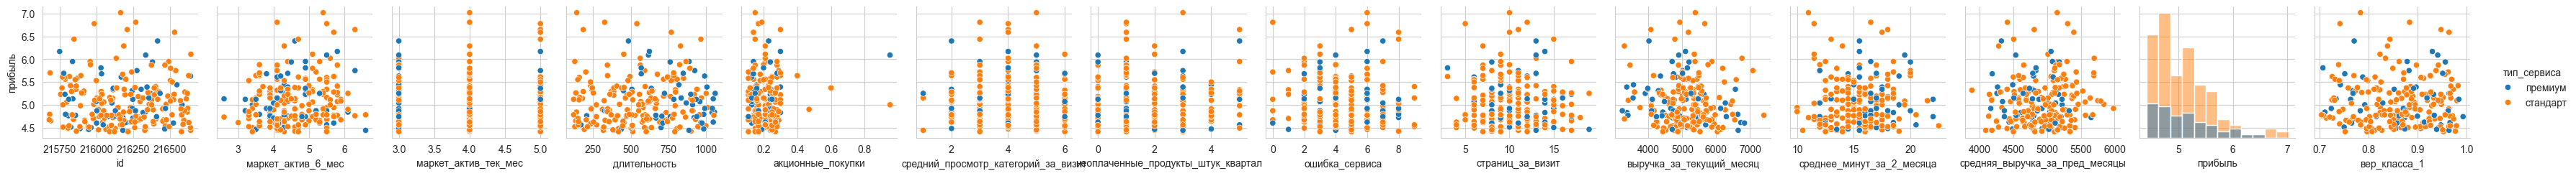

In [62]:
g = sns.PairGrid(target_segment, hue='тип_сервиса', y_vars='прибыль')
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()
plt.show()

Можно отметить что премиум пользователи из исследуемого сегмента больше проводят времени на сайте.

In [63]:
target_quantitative = ['среднее_минут_за_2_месяца', 'страниц_за_визит', 'акционные_покупки', 'маркет_актив_6_мес', ]
target_cat = ['средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'популярная_категория']

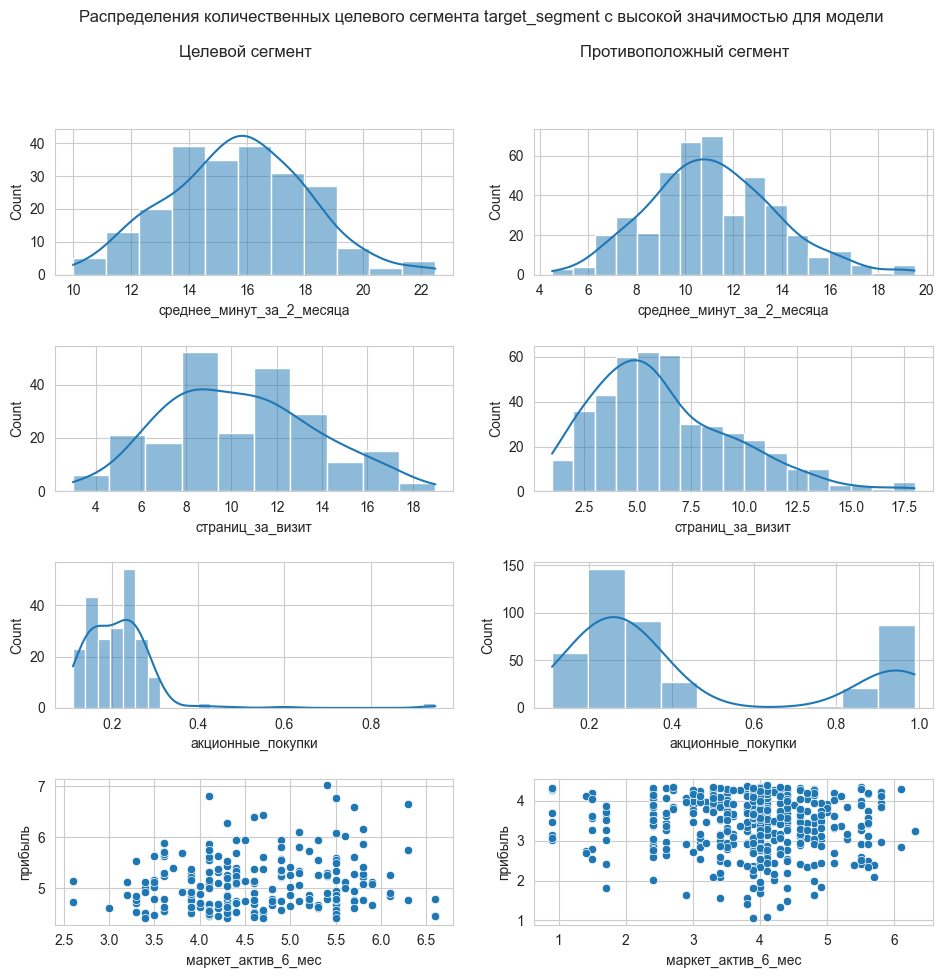

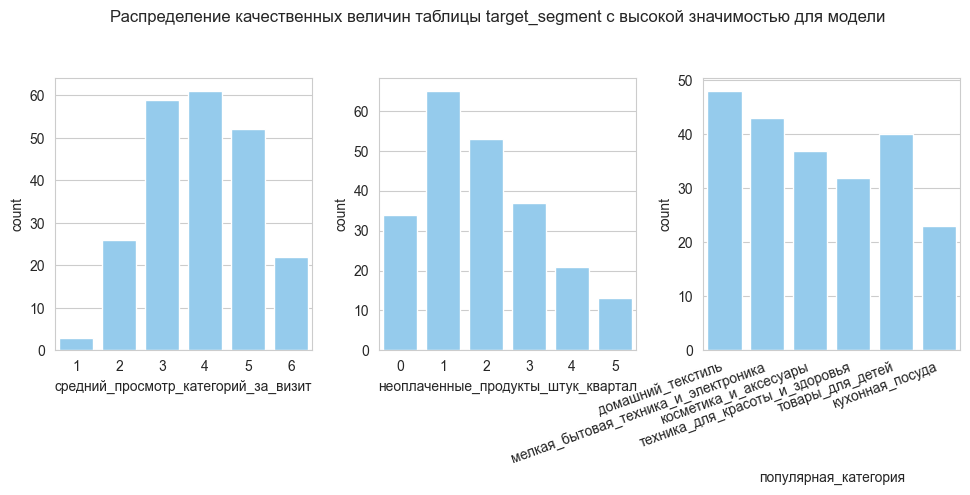

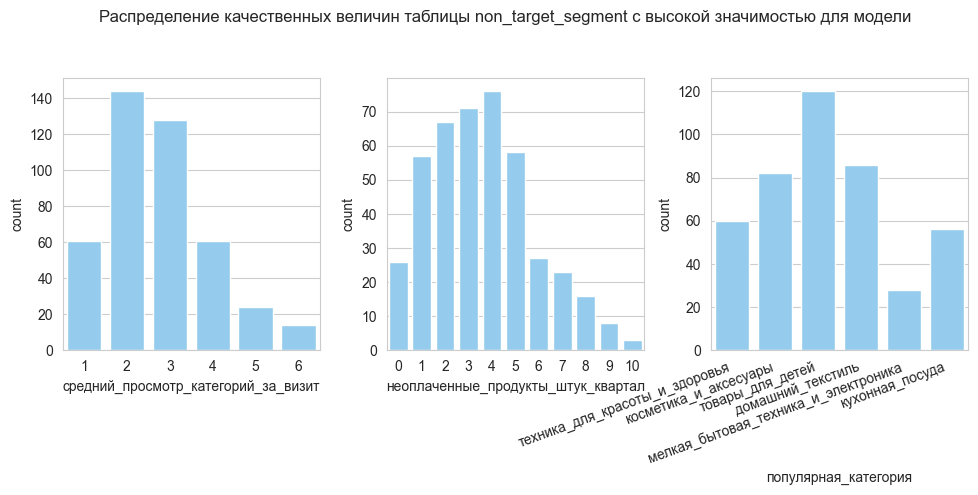

In [64]:
fig, axs = plt.subplots(4, 2, figsize=(10, 10))
fig.suptitle('Распределения количественных целевого сегмента target_segment с высокой значимостью для модели \
\n\nЦелевой сегмент                                                          Противоположный сегмент')
fig.tight_layout(pad=3)

for i, param in enumerate(target_quantitative):
    if param == 'маркет_актив_6_мес':
        sns.scatterplot(data=non_target_segment, x='маркет_актив_6_мес', y='прибыль', ax=axs[i, 1])
        sns.scatterplot(data=target_segment, x='маркет_актив_6_мес', y='прибыль', ax=axs[i, 0])
    else:
        sns.histplot(data=non_target_segment, x=param, kde=True, ax=axs[i, 1])
        sns.histplot(data=target_segment, x=param, kde=True, ax=axs[i, 0])


fig, axs = plt.subplots(1, 3, figsize=(10, 4))
fig.suptitle('Распределение качественных величин таблицы target_segment с высокой значимостью для модели')
fig.tight_layout(pad=2)
for i, param in enumerate(target_cat):
    sns.countplot(data=target_segment, x=param, color='lightskyblue', ax=axs[i])
axs[i].set_xticks(ticks=axs[i].get_xticks(), labels=axs[i].get_xticklabels(), rotation=20, ha='right')

fig, axs = plt.subplots(1, 3, figsize=(10, 4))
fig.suptitle('Распределение качественных величин таблицы non_target_segment с высокой значимостью для модели')
fig.tight_layout(pad=2)
for i, param in enumerate(target_cat):
    sns.countplot(data=non_target_segment, x=param, color='lightskyblue', ax=axs[i])
axs[i].set_xticks(ticks=axs[i].get_xticks(), labels=axs[i].get_xticklabels(), rotation=20, ha='right')


plt.show()

Для данного целеого сегмента можно заметить несколько особенностей и дать советы по удержанию покупателей.
1. У покупателей из исследуемого сегмента увеличилось время проведенное на сайте. Данный признак для модели является одним из самых важных для определения покупательской активности. Мне кажется на этот параметр сложнее всего повлиять, потому что многие люди, средне статистические пользователи маркетплейсов, зачастую просто блуждают по страницам просматривая "нечто интересное" для себя. Здесь особенно важно чтобы была конверсия проведенного времени и желания "полистать ленту" в покупки. Чтобы снизить время можно интегрировать систему подсказок для пользователя, чтобы снизить к минимуму его блуждание по сайту и довести его до покупки. 
2. Среднее количество страниц за визит в этой группе пользователей тоже увеличено. Можно, как вариант, обратить внимание на систему рекомендаций. Возможно, пользователь просто все чаще не может найти подходящий для себя товар.
3. Покупатели из нашего сегмента стали реже пользоваться акциями. Вероятно, стоит предложить скидку или акцию на любимый товар или товар который был ранее добавлен в корзину, чтобы смотивировать человека к покупке, или они просто могут не знать что проводится  данный момент акция. Акции это очень важный и сильный инструмент в продажах.
4. Среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента. Это самый сложно интерпретируемый (лично для меня) параметр. Одно можно сказать точно - увеличение среднего числа маркетинговых коммуникаций еще не залог успеха и большой прибыли, ровно как и без них не обойтись. Золотая середина - от 3 до 5 в месяц.
5. У исследуемого сегмента увеличено среднее количество просмотров категорий за визит. Мне кажется это похожий признак в колилку к п.1 и п.2. Цель - помочь покупателю определиться.
6. Можно стимулирорвать покупателя добавлять товары в корзину. Так, кстати, делают многие маркетплейсы, давая некоторые бонусы, которые потом можно применить в акциях.
7. Наиболее популярная категория исследуемого сегмента домашний текстиль. Интересно узнать какую долю прибыли составляют покупки по категориям и почему самые прибыльные клиенты чаще интересуются домашним текстилем.

## Шаг 9. Общий вывод

В ходе анализа данных по активности постоянных клиентов интернет-магазина «В один клик». Была проделана следующая работа:
>Загрузка данных
Исходными данными для исследования были четыре отдельных csv файла:

с данными о поведении покупателя на сайте, коммуникации с ним и его продуктовом поведении.
с данными о выручке, которую получает магазин с покупателя за период
с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода
данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю Данные были загружены в датафреймы библиотеки pandas.

> Предобработка данных

в ходе работы была выполнена предобработка данных, удалены неявные дубликаты, одно аномальное значение приведено к среднему для пользователя.

> Исследовательский анализ данных

на этом этапе построены графики разпределения признаков. Были подчеркнуты особенности распределения некоторых признаков, например бимодальное распределение акционных покупок. Также выявлено большинство клиентов не резрешают сообщать информацию о том, можно ли присылать покупателю дополнительные предложения о товаре и имеют стандартный тип обслуживания.

> Корреляционный анализ данных

В ходе корреляционного анализа была построена матрица корреляции признаков. Сильной корреляции между другими признаками не было выявлено.

> Объеденение таблиц

Таблицы market_file, market_money, market_time были объеденены в один датафрейм.

> Обучение модели

На данном этапе была проверена работа известных моделей для классификации пользователей по покупательской активности KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и SVC(). Лучшей моделью в ходе исслдования выбрана Лонистическая Регрессия с параметрами приведенными ниже.

In [65]:
best_log_pipeline.named_steps['models']

LogisticRegression(C=0.43, class_weight='balanced', penalty='l1',
                   random_state=1000, solver='saga')

>Анализ важности признаков

С помощью библиотеки SHAP была визуализирована значимость признаков для лучшей модели. Ниже приведен график значимости признаков (по модулю)

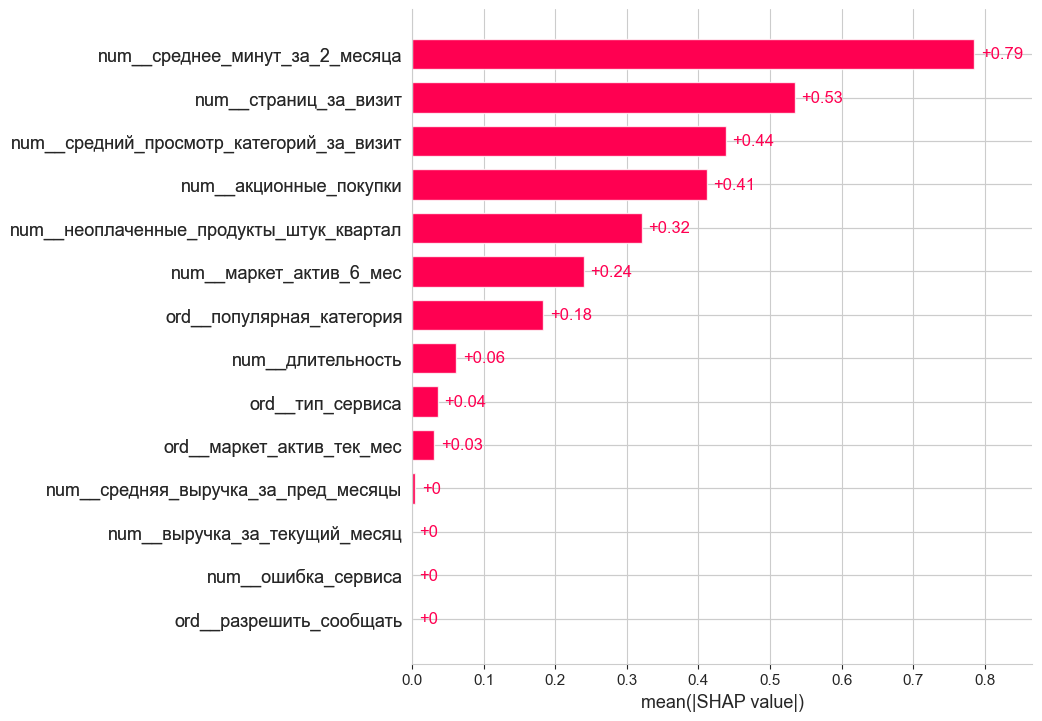

In [66]:
shap.plots.bar(shap_values, max_display=17)

> Сегментация покупателей

В качестве сегмента для анализа была выбрана группа клиентов с высокой вероятностью снижения покупательской активности и наиболее высокой прибыльностью. Выведены графики показывающие отличие исследуемого сегмента от остальной выборки и даны рекомендации.